# Zastosowania DFT
Laboratorium 9 - Metody Obliczeniowe w Nauce i Technice

In [2]:
import cmath
import numpy as np
import scipy.linalg as salg
import matplotlib.pyplot as plt
import time
from functools import reduce
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

## Zadanie 1. Analiza obrazów.
- Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przedstaw wartości fazy i modułu współczynników Fouriera (osobno).
- Wybierz  przykładowego  reprezentanta  grupy  -  wytnij  z  dużego  zdjęcia  wzorzec obiektu np. literę _e_ lub charakterystyczny fragment ryby z ławicy (`imcrop`).
- Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem, a całym obrazem<sup>1</sup>.
- Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpienie wzorca (nałóż je na obraz oryginalny).
- Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.

<sup>1</sup>`C = real( ifft2(fft2(galia) .* fft2(rot90(imp, 2), h, w)) );`

### Wczytanie obrazu i odwrócenie jego kolorów
Na początku wczytuję obraz i odwracam paletę kolorów, aby tło tekstu było czarne, a tekst biały.

#### Tekst

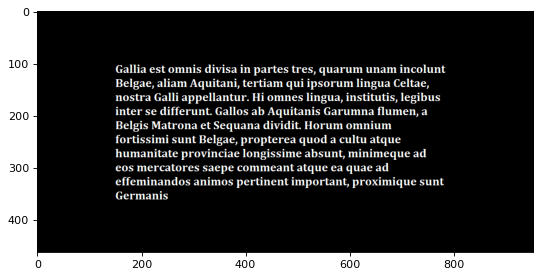

In [3]:
text_image = imread("./images/galia.png")
H, W = len(text_image), len(text_image[0])
inverted_text_image = np.invert(text_image)
gs_text_image = rgb2gray(inverted_text_image)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(inverted_text_image, cmap='gray')

#### Pojedyncza litera (_e_)

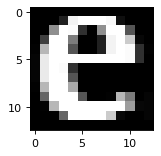

In [4]:
letter = imread("./images/galia-e.png")
inverted_letter = np.invert(letter)
gs_letter = rgb2gray(inverted_letter)
plt.figure(num=None, figsize=(3, 2), dpi=80)
plt.imshow(gs_letter, cmap='gray')

### Szybka transformacja Fouriera tekstu
Po przekształceniu tekstu i litery dokonuję transformacji obrazu, korzystając z FFT z biblioteki `NumPy` (`np.fft`).

In [5]:
# inverted_text_image_fft = np.fft.fftshift(np.fft.fft2(inverted_text_image))
# plt.figure(num=None, figsize=(8, 6), dpi=80)
# plt.imshow(np.log(abs(inverted_text_image_fft)), cmap='gray')

image_fft = np.fft.fft2(gs_text_image)

#### Wizualizacja wyników

##### Wykres argumentów wartości transformacji

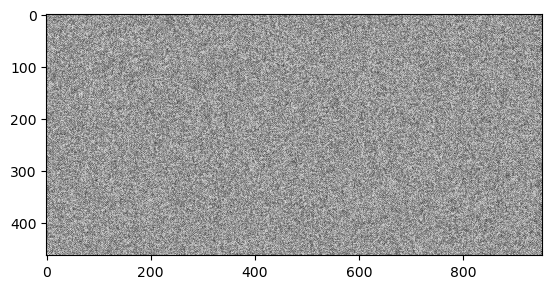

In [6]:
phase_image_fft = np.array([[cmath.phase(c) for c in row] for row in image_fft])
plt.imshow(phase_image_fft, cmap="Greys")
plt.show()

##### Wykres modułów wartości transformacji
Wynik transformacji został zlogarytmowany, ponieważ wartości były zbyt duże i zbliżone do siebie.

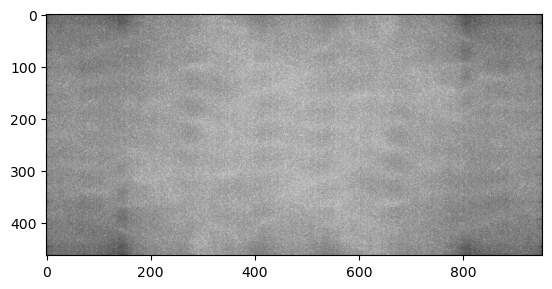

In [7]:
abs_image_fft = np.array([[abs(c) for c in row] for row in image_fft])
plt.imshow(np.log(abs_image_fft), cmap="Greys")
plt.show()

#### Obliczenie korelacji wzorca z bazowym obrazem

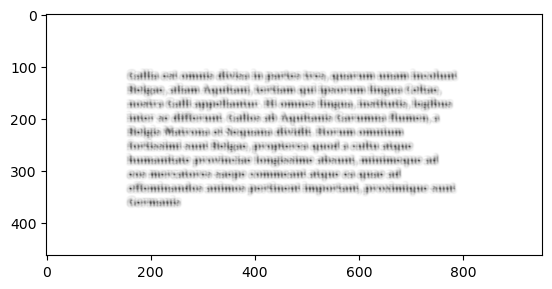

In [8]:
C = np.real(np.fft.ifft2(np.fft.fft2(gs_text_image) * np.fft.fft2(np.rot90(gs_letter, 2), (H, W))))
plt.imshow(C, cmap="Greys")
plt.show()

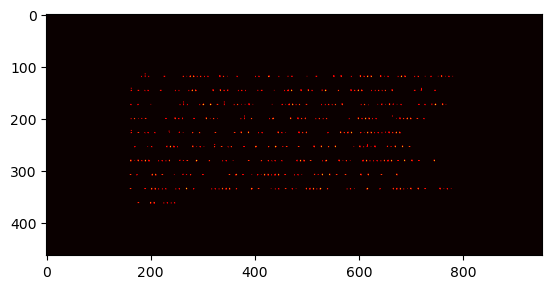

In [19]:
C_filtered = np.where(C > 40, C, 0)
plt.imshow(C_filtered, cmap="hot")
plt.show()

In [23]:
print(inverted_text_image.shape)
c_text_image = np.empty(C_filtered.shape)
for i in range(C_filtered.shape[0]):
    for j in range(C_filtered.shape[1]):
        if C_filtered[i, j] > 0:
            c_text_image[i, j] = (255, 0, 0)

plt.imshow(c_text_image)
plt.show()

(463, 953, 3)


ValueError: operands could not be broadcast together with shapes (463,953) (3,) (3,) 

In [54]:
def find_pattern(correlation, pattern):
    height, width = correlation.shape
    pattern_height, pattern_width = pattern.shape
    for y in range(height - pattern_height):
        for x in range(width - pattern_width):
            pass
            # correlation[]
    print(correlation.max())


find_pattern(C, gs_letter)

55.32542781635585


In [23]:
# np.fft.ifft2(np.fft.fft2(inverted_text_image) * np.fft.fft2(np.rot90(inverted_e_letter, 2), H, W))
np.fft.fft2(np.rot90(inverted_e_letter, 1), H, W)

TypeError: 'int' object is not iterable

## Zadanie 2.